In [414]:
%matplotlib inline
import chainer
import chainer.functions as F
import chainer.links as L
import chainer.cuda
from chainer import optimizers
from chainer import serializers
from chainer import cuda
import numpy as np
import matplotlib.pyplot as plt

In [415]:
n_epoch = 200
batchsize = 100
bprop_len = 10
n_units = 30
grad_clip = 5
use_gpu = False

In [416]:
xp = cuda.cupy if use_gpu is True else np

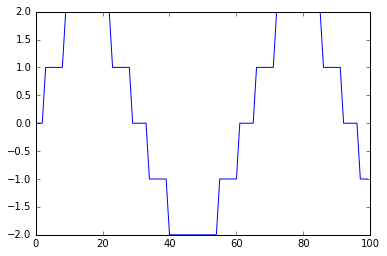

In [417]:
t = np.arange(0,1000,0.1, dtype=np.float32)

train_data = np.sin(t) * np.sin(5 * t)
#train_data = np.asarray([1 if (i/5)%2 == 0 else -1 for i in range(10000)], dtype=np.float32)
#train_data = np.asarray([1 if i%10 < 5 else -1 for i in range(10000)], dtype=np.float32) #10ユニットもあれば十分
#train_data = np.asarray([1 if x > 1 else x for x in 1.5 * np.sin(t)], dtype=np.float32)
#train_data = t % 3
train_data = np.asarray([x.round(0) for x in 2 * np.sin(t)], dtype=np.float32)
plt.plot(train_data[:100])

In [418]:
class RNN(chainer.Chain):
    def __init__(self, n_units):
        super(RNN, self).__init__(
            l1 = L.Linear(1, n_units),
            l2 = L.LSTM(n_units, n_units),
            l3 = L.Linear(n_units, 1)
        )
    
    def __call__(self,x,t):
        return F.mean_squared_error(self.predict(x),t)
        
    def reset_state(self):
        self.l2.reset_state()
    
    def predict(self,x):
        h1 = F.sigmoid(self.l1(x))
        h2 = self.l2(h1)
        y = self.l3(h2)
        return y

In [419]:
#ネットワークを試す関数
def evaluate(model,num,origin=0):
    t = chainer.Variable(xp.array([[origin]],dtype=np.float32))
    output = []
    evaluator = model.copy()
    evaluator.reset_state()
    for i in range(num):
        t = evaluator.predict(t)
        output.append(t.data[0])
    return output

In [420]:
model = RNN(n_units)
if use_gpu is True:
    model.to_gpu()
#optimizer = optimizers.SGD(lr=1.)
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
length = train_data.shape[0]
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([[train_data[(jump * j + i) % length]] for j in batch_idxs]))
    t = chainer.Variable(xp.asarray([[train_data[(jump * j + i + 1) % length]] for j in batch_idxs]))
    loss_i = model(x,t)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        #if epoch > 5:
        #    optimizer.lr /= 1.3
        print('epoch {}, error {}'.format(epoch, loss_data / length))
        loss.append(loss_data / length)
        loss_data = 0
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()


epoch 1, error 0.08572039395570755
epoch 2, error 0.04712601606249809
epoch 3, error 0.026485441794991495
epoch 4, error 0.014007901802659034
epoch 5, error 0.009273950745165347
epoch 6, error 0.007094660893827677
epoch 7, error 0.006174504405260086
epoch 8, error 0.006704768677055836
epoch 9, error 0.005946965384483338
epoch 10, error 0.005106856682151556
epoch 11, error 0.004774494199454784
epoch 12, error 0.004536857645958662
epoch 13, error 0.004427584154903888
epoch 14, error 0.0043336849369108674
epoch 15, error 0.004284616197645664
epoch 16, error 0.004384669671207667
epoch 17, error 0.004514048161357641
epoch 18, error 0.0048415754780173305
epoch 19, error 0.005498472613096237
epoch 20, error 0.005908983819931745
epoch 21, error 0.006492523895204067
epoch 22, error 0.006943162477761507
epoch 23, error 0.00813604587316513
epoch 24, error 0.007832142923772335
epoch 25, error 0.00744746763035655
epoch 26, error 0.006148585624992847
epoch 27, error 0.005633937810361385
epoch 28, er

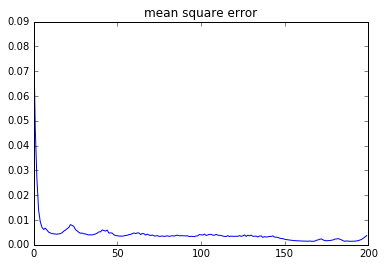

In [421]:
plt.plot(loss)
plt.title('mean square error')

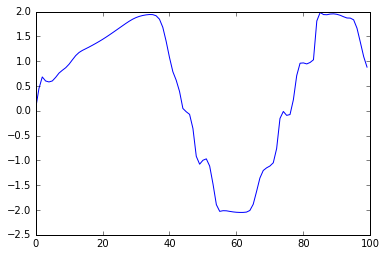

In [426]:
output = evaluate(model,400,origin=0)
plt.plot(output[:100])

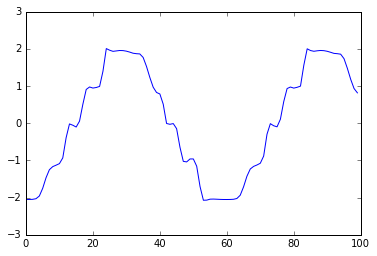

In [427]:
plt.plot(output[300:400])